In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from math import ceil
import multiprocessing
from collections import Counter
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import matplotlib.patches as mpatches
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from memory_profiler import memory_usage
import time
import torchvision.models as models
from collections import OrderedDict

/mmfs1/cm/shared/apps_local/python/3.11/envs/torch2.2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataset_path, gt_masks_path=None, num_sequences=None, is_training=True, transform=None, target_size=(224, 144), segment_length=17):
        self.dataset_path = dataset_path
        self.gt_masks_path = gt_masks_path
        self.num_sequences = num_sequences
        self.is_training = is_training
        self.transform = transform
        self.target_size = target_size
        self.segment_length = segment_length
        self.max_track_id = 19  
        self.track_id_mapping = self.create_track_id_mapping()
        self.sequence_folders = sorted(os.listdir(self.dataset_path))
        # Filter out the ground truth folders and unwanted folders
        self.sequence_folders = sorted([
            folder for folder in os.listdir(self.dataset_path) 
            if os.path.isdir(os.path.join(self.dataset_path, folder)) 
            and '_gt' not in folder 
            and '.ipynb_checkpoints' not in folder
        ])
    def create_track_id_mapping(self):
        track_ids = np.arange(1, self.max_track_id + 1)
        normalized_track_ids = track_ids / self.max_track_id
        track_id_mapping = dict(zip(track_ids, normalized_track_ids))
        return track_id_mapping

    def create_segments(self, frames, labels, segment_length=11):
        num_frames = len(frames)
        half_segment = segment_length // 2

        segments = []
        segment_labels = []

        for i in range(num_frames):
            segment = []

            for j in range(i - half_segment, i):
                if j < 0:
                    segment.append(np.zeros_like(frames[0])) 
                else:
                    segment.append(frames[j])

            segment.append(frames[i])

            for j in range(i + 1, i + 1 + half_segment):
                if j >= num_frames:
                    segment.append(np.zeros_like(frames[0])) 
                else:
                    segment.append(frames[j])
           
            segments.append(segment)
            segment_labels.append(labels[i])     
        
        return segments, segment_labels
    
    def process_sequence(self, sequence_folder):        
        sequence_path = os.path.join(self.dataset_path, sequence_folder)
        # Check if the sequence folder is a directory and doesn't contain '_gt' or '.ipynb_checkpoints'
        if not os.path.isdir(sequence_path):
            return [], [], []
    
        
        sequence_frames = []
        sequence_tracking_data = []
        sequence_labels = []
        
        label_folder = os.path.join(sequence_path, 'labels')
        if not os.path.exists(label_folder):
            return [], [], []

        tracking_data = {}

        for label_file in sorted(os.listdir(label_folder)):
            if not label_file.endswith('.txt'):
                continue

            frame_id = int(os.path.splitext(label_file)[0])
            tracking_data[frame_id] = []

            with open(os.path.join(label_folder, label_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    line_split = line.strip().split(' ')
                    if len(line_split) < 6:
                        continue

                    x = float(line_split[1])
                    y = float(line_split[2])
                    width = float(line_split[3])
                    height = float(line_split[4])
                    track_id = int(line_split[5])
                    tracking_data[frame_id].append({'track_id': track_id, 'x': x, 'y': y, 'width': width, 'height': height})

        for frame_index, track_data_list in tracking_data.items():
            img_filename = "{:03d}.tif".format(frame_index)
            img_path = os.path.join(sequence_path, img_filename)
            frame = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            #frame = cv2.resize(frame, self.target_size, interpolation=cv2.INTER_AREA)

            tracking_data_channel = np.zeros_like(frame, dtype=np.float32)                

            for track_data in track_data_list:
                x, y = track_data['x'], track_data['y']
                width, height = track_data['width'], track_data['height']
                track_id = track_data['track_id']
                normalized_track_id = self.track_id_mapping.get(track_id, 0.0)

                x_pixel = int(x * frame.shape[1])
                y_pixel = int(y * frame.shape[0])
                width_pixel = int(width * frame.shape[1])
                height_pixel = int(height * frame.shape[0])

                for y_idx in range(y_pixel, y_pixel + height_pixel):
                    for x_idx in range(x_pixel, x_pixel + width_pixel):
                        if 0 <= x_idx < frame.shape[1] and 0 <= y_idx < frame.shape[0]:
                            tracking_data_channel[y_idx, x_idx] = normalized_track_id                                

            frame = np.expand_dims(frame, axis=-1)            
            tracking_data_channel = np.expand_dims(tracking_data_channel, axis=-1)
            # Convert numpy arrays to PIL Images
            frame_pil = Image.fromarray(frame.squeeze(axis=-1))
            tracking_data_channel_pil = Image.fromarray(tracking_data_channel.squeeze(axis=-1))
            # Apply transformations
            if self.transform:
                seed = np.random.randint(0, 2**32)  # Generate random seed
                random.seed(seed)
                torch.manual_seed(seed)

                frame_pil = self.transform(frame_pil)
                random.seed(seed)  # Reset the seed
                torch.manual_seed(seed)

                tracking_data_channel_pil = self.transform(tracking_data_channel_pil)
            # Convert the transformed PIL images back to numpy arrays
            frame = np.array(frame_pil)
            
            tracking_data_channel = np.array(tracking_data_channel_pil)
            frame = np.expand_dims(frame, axis=-1)   
            tracking_data_channel = np.expand_dims(tracking_data_channel, axis=-1)               
            sequence_frames.append(frame)           
            sequence_tracking_data.append(tracking_data_channel)

            if not self.is_training and self.gt_masks_path:
                gt_mask_path = os.path.join(self.gt_masks_path, sequence_folder + "_gt", img_filename.replace('.tif', '.bmp'))
                if os.path.exists(gt_mask_path):
                    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
                    if gt_mask is not None:
                        label = int(np.max(gt_mask) > 0)
                        sequence_labels.append(label)
                    else:
                        label = 0
                        sequence_labels.append(label)
                else:
                    label = 0
                    sequence_labels.append(label)
            elif self.is_training:
                label = 0
                sequence_labels.append(label)

        segment_frames, segment_labels = self.create_segments(sequence_frames, sequence_labels, segment_length=self.segment_length)
        segment_tracking_data, _ = self.create_segments(sequence_tracking_data, segment_labels, segment_length=self.segment_length)

        segment_frames = np.stack(segment_frames)
        segment_tracking_data = np.stack(segment_tracking_data)
        segment_labels = np.stack(segment_labels)
        return segment_frames, segment_tracking_data, segment_labels

    def __len__(self):
        return len(self.sequence_folders)

    def __getitem__(self, idx):
        sequence_folder = self.sequence_folders[idx]
        segment_frames, segment_tracking_data, segment_labels = self.process_sequence(sequence_folder)
        return segment_frames, segment_tracking_data, segment_labels


In [3]:
# Define the dataset path and ground truth masks path
train_dataset_path = '/mmfs1/scratch/jacks.local/ojanigala/Anomaly_Detection/UCSDped1/Train'  # Path to the train dataset
test_dataset_path = '/mmfs1/scratch/jacks.local/ojanigala/Anomaly_Detection/UCSDped1/Test'    # Path to the test dataset
test_gt_masks_path = '/mmfs1/scratch/jacks.local/ojanigala/Anomaly_Detection/UCSDped1/Test'   # Path to the test ground truth masks

# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])



# try:
    # Initialize the dataset for training and testing
train_dataset = CustomDataset(train_dataset_path, is_training=True)
test_dataset = CustomDataset(test_dataset_path, gt_masks_path=test_gt_masks_path, is_training=False)
    
# except Exception as e:
#     print("Error loading datasets:", e)
#     exit(1)


# Calculate the split index
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(train_dataset)))

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)


In [4]:
# Set a unique seed value for this notebook
SEED = 42  

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


batch_size = 1
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



train_subset_length = len(train_subset)
val_subset_length = len(val_subset)
test_length = len(test_dataset)

print(f"Number of samples in the train subset: {train_subset_length}")
print(f"Number of samples in the val subset: {val_subset_length}")
print(f"Number of samples in the test: {test_length}")

for i, batch in enumerate(train_loader):
    frames, tracking_data, labels = batch
    print("Batch Frames shape:", frames.shape)
    print("Batch Tracking Data shape:", tracking_data.shape)
    print("Batch Labels shape:", labels.shape)
    if i == 0: 
        break


Number of samples in the train subset: 27
Number of samples in the val subset: 7
Number of samples in the test: 36
Batch Frames shape: torch.Size([1, 200, 17, 158, 238, 1])
Batch Tracking Data shape: torch.Size([1, 200, 17, 158, 238, 1])
Batch Labels shape: torch.Size([1, 200])


In [7]:
def print_memory_usage():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

        
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * self.expansion),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        # print("BasicBlock Module...")
        # print_memory_usage()
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv3 = nn.Conv3d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * self.expansion),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)  
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)  
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        # print("Bottleneck Module...")
        # print_memory_usage()
        return out

        
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.max_pool = nn.AdaptiveMaxPool3d(1)

        self.fc = nn.Sequential(
            nn.Conv3d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv3d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(1)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        out = self.bn(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim, num_heads, height, width, frame_channel, track_channel, output_channels=512):
        super(CrossAttentionFusion, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.height = height
        self.width = width
        self.frame_channel = frame_channel
        self.track_channel = track_channel
        self.output_channels = output_channels

        # Calculate the flattened input size based on image dimensions
        frame_flattened_size = self.frame_channel * self.height * self.width  # 1 * 158 * 238 = 37564
        tracking_flattened_size = self.track_channel * self.height * self.width  # 1 * 158 * 238 = 37564

        # Adjust the linear layers to match the correct flattened size
        self.frame_embed = nn.Linear(frame_flattened_size, embed_dim)
        self.tracking_embed = nn.Linear(tracking_flattened_size, embed_dim)
        
        self.cross_attention = nn.MultiheadAttention(embed_dim, num_heads)
        
        self.output_conv = nn.Conv2d(embed_dim, output_channels, kernel_size=1)
        
    def forward(self, frames, tracking_data):
        batch_size, num_channels_frames, num_frames, height, width = frames.shape
        _, num_channels_tracking, num_tracking_frames, _, _ = tracking_data.shape
    
        # Flatten each frame and tracking data to be used as tokens
        frames_flat = frames.reshape(batch_size * num_frames, -1)  # Flatten to (batch_size * num_frames, flattened_size)
        tracking_data_flat = tracking_data.reshape(batch_size * num_tracking_frames, -1)  # Same for tracking data
    
        # print(f"Flattened frames shape: {frames_flat.shape}")  # Debugging line
        # print(f"Flattened tracking data shape: {tracking_data_flat.shape}")  # Debugging line

        # Embed tokens
        frames_embedded = self.frame_embed(frames_flat)  # Shape: (batch_size * num_frames, embed_dim)
        tracking_embedded = self.tracking_embed(tracking_data_flat)  # Shape: (batch_size * num_tracking_frames, embed_dim)
    
        # Create query, key, and value for cross-attention
        query = frames_embedded
        key = tracking_embedded
        value = frames_embedded
        
        attn_output, attn_weights = self.cross_attention(query, key, value)
        
        attn_output = attn_output.transpose(0, 1)  # Shape: (batch_size, num_frames, embed_dim)
        
        # Reshape for convolutional layer
        attn_output = attn_output.reshape(batch_size, self.embed_dim, num_frames, 1)  # Shape: (batch_size, embed_dim, num_frames, 1)
        
        attn_output = self.output_conv(attn_output)  # Shape: (batch_size, output_channels, num_frames, 1)
        
        # Reshape to match the original input dimensions (batch_size, output_channels, num_frames, height, width)
        attn_output = attn_output.view(batch_size, self.output_channels, num_frames, 1, 1)  # Shape: (batch_size, output_channels, num_frames, 1, 1)
        attn_output = attn_output.expand(-1, -1, -1, self.height, self.width)  # Expand to (batch_size, output_channels, num_frames, height, width)
        
        return attn_output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1, in_channels=1):
        super(ResNet3D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout3d(p=0.5)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class ResNet3D_CBAM(ResNet3D):
    def __init__(self, block, layers, num_classes=1, in_channels=1):
        super(ResNet3D_CBAM, self).__init__(block, layers, num_classes, in_channels)
        
        # CBAM modules for the ResNet3D layers
        self.cbam1 = CBAM(64 * block.expansion)
        self.cbam2 = CBAM(128 * block.expansion)
        self.cbam3 = CBAM(256 * block.expansion)
        self.cbam4 = CBAM(512 * block.expansion)

        # Cross-Attention for late fusion
        self.embed_dim = 512  # Match this to the ResNet output dimension
        self.num_heads = 4
        self.cross_attention = CrossAttentionFusion(embed_dim=self.embed_dim, num_heads=self.num_heads,
                                                    height=5, width=8, 
                                                    frame_channel=512, track_channel=512, output_channels=512).to(device)

        # Final classification layer after fusion
        self.fc_final = nn.Linear(512, num_classes)

    def forward(self, x_frames, x_track):
        # Process frames modality
        x_frames = self.conv1(x_frames)
        x_frames = self.bn1(x_frames)
        x_frames = self.relu(x_frames)
        x_frames = self.maxpool(x_frames)

        x_frames = self.layer1(x_frames)
        x_frames = self.cbam1(x_frames)
        x_frames = self.layer2(x_frames)
        x_frames = self.cbam2(x_frames)
        x_frames = self.layer3(x_frames)
        x_frames = self.cbam3(x_frames)
        x_frames = self.layer4(x_frames)
        x_frames = self.cbam4(x_frames)
        #print("x_frames:",x_frames.shape)
        # Process tracking data modality (same ResNet3D processing)
        x_track = self.conv1(x_track)
        x_track = self.bn1(x_track)
        x_track = self.relu(x_track)
        x_track = self.maxpool(x_track)

        x_track = self.layer1(x_track)
        x_track = self.cbam1(x_track)
        x_track = self.layer2(x_track)
        x_track = self.cbam2(x_track)
        x_track = self.layer3(x_track)
        x_track = self.cbam3(x_track)
        x_track = self.layer4(x_track)
        x_track = self.cbam4(x_track)
        #print("x_track:",x_track.shape)
        # Apply cross-attention to fuse the modalities
        x_fused = self.cross_attention(x_frames, x_track)

        # Perform pooling and classification on the fused output
        x_fused = self.avgpool(x_fused)
        x_fused = x_fused.view(x_fused.size(0), -1)

        # Final classification layer
        x_out = self.fc_final(x_fused)

        return x_out




def resnet10_cbam(in_channels=1):
    return ResNet3D_CBAM(BasicBlock, [1, 1, 1, 1], in_channels=in_channels)

def resnet18_cbam(in_channels=1):
    return ResNet3D_CBAM(BasicBlock, [2, 2, 2, 2], in_channels=in_channels)

def resnet34_cbam(in_channels=1):
    return ResNet3D_CBAM(BasicBlock, [3, 4, 6, 3], in_channels=in_channels)

def resnet50_cbam(in_channels=1):
    return ResNet3D_CBAM(Bottleneck, [3, 4, 6, 3], in_channels=in_channels)



Using 2 GPUs!
Epoch 1/200, Train Loss: 0.664908, Train Accuracy: 57.31%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 1/200, Val Loss: 0.653565, Val Accuracy: 79.29%, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch 2/200, Train Loss: 0.478625, Train Accuracy: 92.50%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 2/200, Val Loss: 0.502778, Val Accuracy: 94.00%, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch 3/200, Train Loss: 0.258896, Train Accuracy: 98.17%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 3/200, Val Loss: 0.344248, Val Accuracy: 100.00%, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch 4/200, Train Loss: 0.106156, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 4/200, Val Loss: 0.245229, Val Accuracy: 100.00%, Val Precision: 1.0000, Val Recall: 1.0000, Val F1: 1.0000
Epoch 5/200, Train Loss: 0.039199, Trai

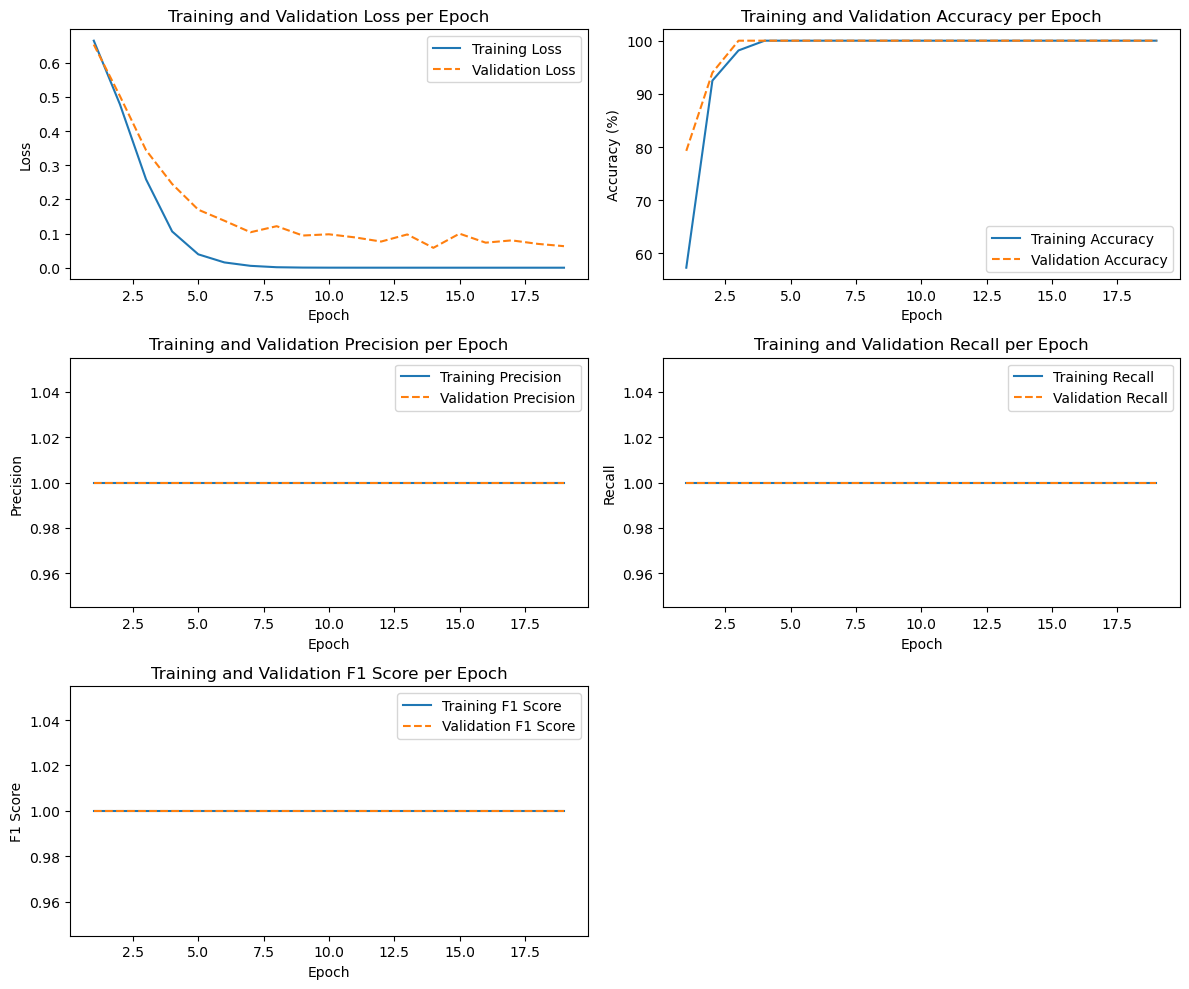

In [31]:
# Define model, criterion, optimizer, and scheduler
model = resnet34_cbam(in_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.000002, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use DataParallel to utilize multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)

# Training model with Early Stopping 
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_aucs = []
    val_aucs = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_preds = []
        
        for frames, tracking_data, labels in train_loader:
            frames, tracking_data, labels = frames.to(device), tracking_data.to(device), labels.to(device)
            frames, tracking_data, labels = frames.float(), tracking_data.float(), labels.float()
            
            # Flatten the first two dimensions (batch, frames)
            frames = frames.view(-1, frames.shape[1], frames.shape[2], frames.shape[3], frames.shape[4])
            #print(frames.shape)
            frames= frames.permute(1, 0, 2, 3, 4)  
            #print(frames.shape)
            tracking_data = tracking_data.view(-1, tracking_data.shape[1], tracking_data.shape[2], tracking_data.shape[3],tracking_data.shape[4])
            tracking_data = tracking_data.permute(1, 0, 2, 3, 4)          
           
            labels = labels.view(-1)
           
            optimizer.zero_grad()
            outputs = model(frames, tracking_data)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            predicted_train = torch.sigmoid(outputs.view(-1)) > 0.5
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            # Collect labels and predictions for AUC and other metrics
            all_train_labels.append(labels.cpu().numpy())
            all_train_preds.append(outputs.view(-1).cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        #train_auc = roc_auc_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds))
        train_precision = precision_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds) > 0.5,average='weighted',zero_division=1)
        train_recall = recall_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds) > 0.5,average='weighted',zero_division=1)
        train_f1 = f1_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds) > 0.5,average='weighted',zero_division=1)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        #train_aucs.append(train_auc)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_val_labels = []
        all_val_preds = []
        
        with torch.no_grad():
            for frames, tracking_data, labels in val_loader:
                frames, tracking_data, labels = frames.to(device), tracking_data.to(device), labels.to(device)
                frames, tracking_data, labels = frames.float(), tracking_data.float(), labels.float()
                
                # Flatten the first two dimensions (batch, frames)
                frames = frames.view(-1, frames.shape[1], frames.shape[2], frames.shape[3], frames.shape[4])
                frames= frames.permute(1, 0, 2, 3, 4)            
                tracking_data = tracking_data.view(-1, tracking_data.shape[1], tracking_data.shape[2], tracking_data.shape[3],tracking_data.shape[4])
                tracking_data = tracking_data.permute(1, 0, 2, 3, 4)    
                labels = labels.view(-1)
                
                outputs = model(frames, tracking_data)
                loss = criterion(outputs.view(-1), labels)
                val_loss += loss.item()

                # Calculate accuracy
                predicted_val = torch.sigmoid(outputs.view(-1)) > 0.5
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
                
                # Collect labels and predictions for AUC and other metrics
                all_val_labels.append(labels.cpu().numpy())
                all_val_preds.append(outputs.view(-1).cpu().detach().numpy())

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        #val_auc = roc_auc_score(np.concatenate(all_val_labels), np.concatenate(all_val_preds))
        val_precision = precision_score(np.concatenate(all_val_labels),np.concatenate(all_val_preds) > 0.5,average='weighted',zero_division=1)
        val_recall = recall_score(np.concatenate(all_val_labels), np.concatenate(all_val_preds) > 0.5,average='weighted',zero_division=1)
        val_f1 = f1_score(np.concatenate(all_val_labels), np.concatenate(all_val_preds) > 0.5,average='weighted',zero_division=1)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        #val_aucs.append(val_auc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_loss:.6f}, Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve_epochs = 0
            torch.save(best_model_state, 'best_model.pth')
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break

    # Load the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, train_accuracies, val_accuracies, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s

# Timing training / validation
start_time = time.time()
model, train_losses, val_losses, train_accuracies, val_accuracies, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=200, patience=5)
end_time = time.time()
train_val_duration = end_time - start_time
print(f"Training / Valdiation Time: {train_val_duration:.2f} seconds")
# Plotting the metrics
plt.figure(figsize=(12, 10))

# Plot training and validation loss
plt.subplot(3, 2, 1)
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Loss', linestyle='-')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(3, 2, 2)
plt.plot(np.arange(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', linestyle='-')
plt.plot(np.arange(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()

# Plot training and validation Precision
plt.subplot(3, 2, 3)
plt.plot(np.arange(1, len(train_precisions) + 1), train_precisions, label='Training Precision', linestyle='-')
plt.plot(np.arange(1, len(val_precisions) + 1), val_precisions, label='Validation Precision', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision per Epoch')
plt.legend()

# Plot training and validation Recall
plt.subplot(3, 2, 4)
plt.plot(np.arange(1, len(train_recalls) + 1), train_recalls, label='Training Recall', linestyle='-')
plt.plot(np.arange(1, len(val_recalls) + 1), val_recalls, label='Validation Recall', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall per Epoch')
plt.legend()


# Plot training and validation F1 Score
plt.subplot(3, 2, 5)
plt.plot(np.arange(1, len(train_f1s) + 1), train_f1s, label='Training F1 Score', linestyle='-')
plt.plot(np.arange(1, len(val_f1s) + 1), val_f1s, label='Validation F1 Score', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
print(f'Average Train Loss: {np.mean(train_losses)}')
print(f'Average Val Loss: {np.mean(val_losses)}')
print(f'Average Train Accuracy: {np.mean(train_accuracies)}')
print(f'Average Val Accuracy: {np.mean(val_accuracies)}') 
print(f'Average Train Accuracy: {np.mean(train_precisions)}')
print(f'Average Val Accuracy: {np.mean(val_precisions)}') 
print(f'Average Train Accuracy: {np.mean(train_recalls)}')
print(f'Average Val Accuracy: {np.mean(val_recalls)}') 
print(f'Average Train Accuracy: {np.mean(train_f1s)}')
print(f'Average Val Accuracy: {np.mean(val_f1s)}') 

Average Train Loss: 0.08268176226602895
Average Val Loss: 0.16726140302598924
Average Train Accuracy: 97.26218323586745
Average Val Accuracy: 98.59398496240601
Average Train Accuracy: 1.0
Average Val Accuracy: 1.0
Average Train Accuracy: 1.0
Average Val Accuracy: 1.0
Average Train Accuracy: 1.0
Average Val Accuracy: 1.0


Using 2 GPUs!
Epoch 1/14, Train Loss: 0.638774, Train Accuracy: 88.46%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 2/14, Train Loss: 0.434731, Train Accuracy: 93.99%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 3/14, Train Loss: 0.184845, Train Accuracy: 99.38%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 4/14, Train Loss: 0.052801, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 5/14, Train Loss: 0.016035, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 6/14, Train Loss: 0.005250, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 7/14, Train Loss: 0.001145, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch 8/14, Train Loss: 0.000260, Train Accuracy: 100.00%, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Epoch

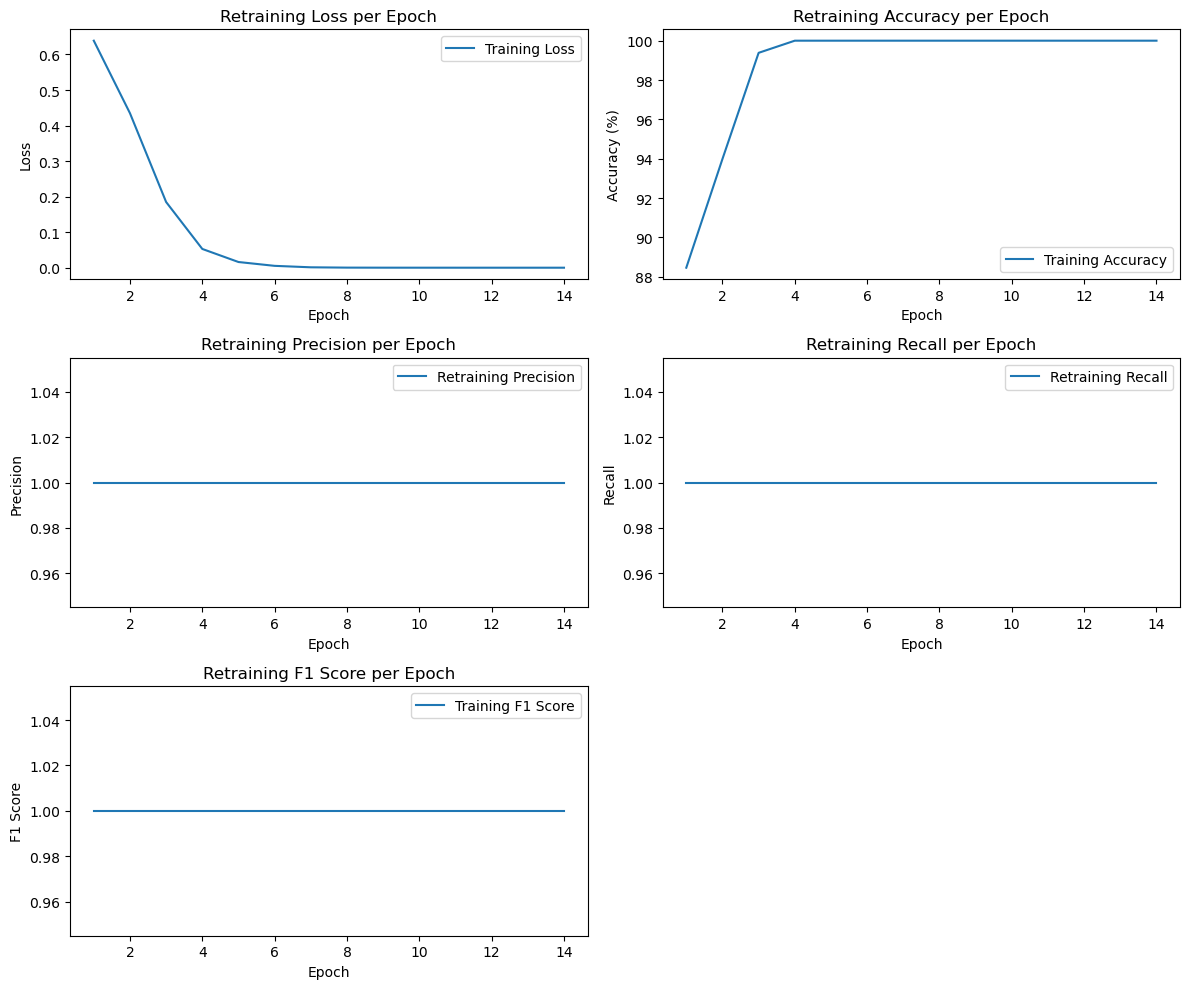

In [33]:
# Define model, criterion, optimizer, and scheduler
model = resnet34_cbam(in_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.000002, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use DataParallel to utilize multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)
def retrain_model(model, full_train_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    retrain_losses = []
    retrain_accuracies = []
    retrain_aucs = []    
    retrain_precisions = []    
    retrain_recalls = []   
    retrain_f1s = []    
    best_retrain_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        retrain_loss = 0.0
        correct_retrain = 0
        total_retrain = 0
        all_retrain_labels = []
        all_retrain_preds = []
        
        for frames, tracking_data, labels in full_train_loader:
            frames, tracking_data, labels = frames.to(device), tracking_data.to(device), labels.to(device)
            frames, tracking_data, labels = frames.float(), tracking_data.float(), labels.float()
            
            # Flatten the first two dimensions (batch, frames)
            frames = frames.view(-1, frames.shape[1], frames.shape[2], frames.shape[3], frames.shape[4])
            frames= frames.permute(1, 0, 2, 3, 4)            
            tracking_data = tracking_data.view(-1, tracking_data.shape[1], tracking_data.shape[2], tracking_data.shape[3],tracking_data.shape[4])
            tracking_data = tracking_data.permute(1, 0, 2, 3, 4)     
           
            labels = labels.view(-1)
           
            optimizer.zero_grad()
            outputs = model(frames, tracking_data)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            retrain_loss += loss.item()

            # Calculate accuracy
            predicted_retrain = torch.sigmoid(outputs.view(-1)) > 0.5
            total_retrain += labels.size(0)
            correct_retrain += (predicted_retrain == labels).sum().item()
            
            # Collect labels and predictions for AUC and other metrics
            all_retrain_labels.append(labels.cpu().numpy())
            all_retrain_preds.append(outputs.view(-1).cpu().detach().numpy())

        retrain_loss /= len(full_train_loader)
        retrain_accuracy = 100 * correct_retrain / total_retrain
        #train_auc = roc_auc_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds))
        retrain_precision = precision_score(np.concatenate(all_retrain_labels), np.concatenate(all_retrain_preds) > 0.5,average='weighted',zero_division=1)
        retrain_recall = recall_score(np.concatenate(all_retrain_labels), np.concatenate(all_retrain_preds) > 0.5,average='weighted',zero_division=1)
        retrain_f1 = f1_score(np.concatenate(all_retrain_labels), np.concatenate(all_retrain_preds) > 0.5,average='weighted',zero_division=1)
        
        retrain_losses.append(retrain_loss)
        retrain_accuracies.append(retrain_accuracy)
        #train_aucs.append(train_auc)
        retrain_precisions.append(retrain_precision)
        retrain_recalls.append(retrain_recall)
        retrain_f1s.append(retrain_f1)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {retrain_loss:.6f}, Train Accuracy: {retrain_accuracy:.2f}%, Train Precision: {retrain_precision:.4f}, Train Recall: {retrain_recall:.4f}, Train F1: {retrain_f1:.4f}')

              
        
    return model, retrain_losses, retrain_accuracies, retrain_precisions, retrain_recalls, retrain_f1s, 

# Timing retraining 
retraining_start_time = time.time()
model, retrain_losses, retrain_accuracies, retrain_precisions, retrain_recalls, retrain_f1s = retrain_model(model, full_train_loader, criterion, optimizer, scheduler, num_epochs=14, patience=1)
retraining_end_time = time.time()
retraining_duration = (retraining_end_time - retraining_start_time)/60
print(f"Retraining Duration: {retraining_duration:.2f} minutes")
# Plotting the metrics
plt.figure(figsize=(12, 10))

# Plot retraining loss
plt.subplot(3, 2, 1)
plt.plot(np.arange(1, len(retrain_losses) + 1), retrain_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Retraining Loss per Epoch')
plt.legend()

# Plot retraining accuracy
plt.subplot(3, 2, 2)
plt.plot(np.arange(1, len(retrain_accuracies) + 1), retrain_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Retraining Accuracy per Epoch')
plt.legend()

# Plot retraining Precision
plt.subplot(3, 2, 3)
plt.plot(np.arange(1, len(retrain_precisions) + 1), retrain_precisions, label='Retraining Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Retraining Precision per Epoch')
plt.legend()

# Plot retraining Recall
plt.subplot(3, 2, 4)
plt.plot(np.arange(1, len(retrain_recalls) + 1), retrain_recalls, label='Retraining Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Retraining Recall per Epoch')
plt.legend()

# Plot retraining F1 Score
plt.subplot(3, 2, 5)
plt.plot(np.arange(1, len(retrain_f1s) + 1), retrain_f1s, label='Training F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Retraining F1 Score per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
print(f'Average Retrain Loss: {np.mean(retrain_losses)}')
print(f'Average Rerain Accuracy: {np.mean(retrain_accuracies)}')

Average Retrain Loss: 0.09529533966201978
Average Rerain Accuracy: 98.7016806722689


Batch Loss: 0.0131, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0136, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0138, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0133, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0135, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0127, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0127, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0130, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0138, Batch Accuracy: 100.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Batch Loss: 0.0134, Batch Accuracy: 100.0000, Precision

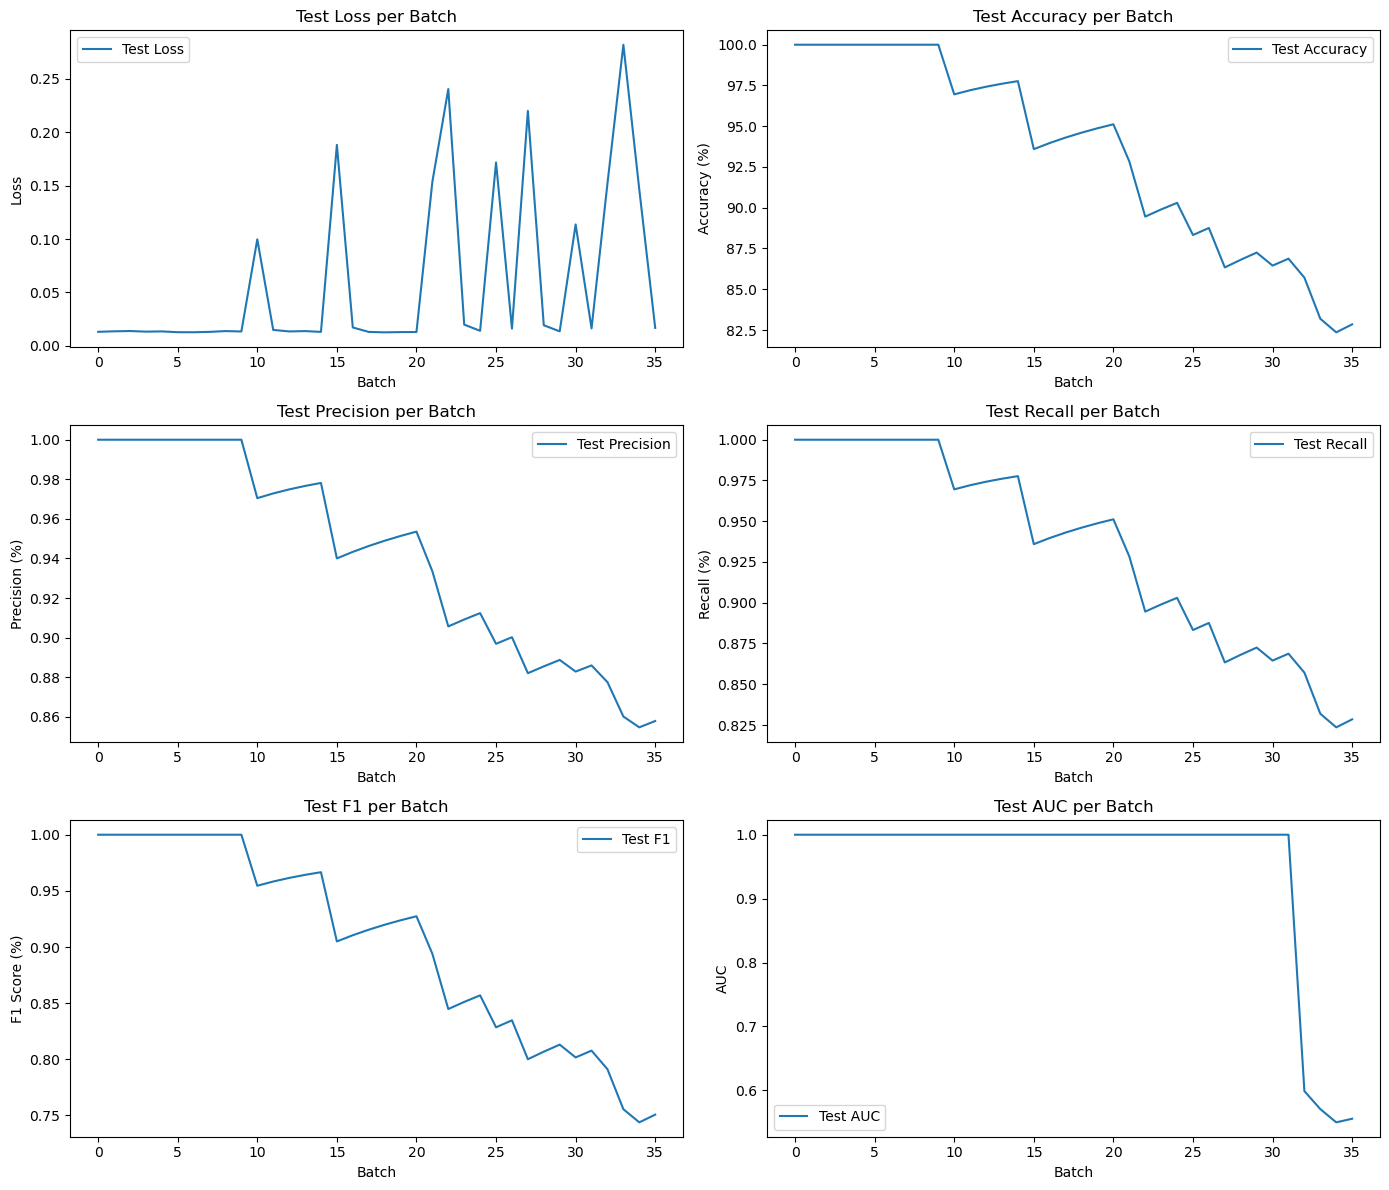

In [98]:
def test(model, test_loader, criterion, optimizer, scheduler, device):
    model.eval()
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []
    test_aucs = []
    all_test_labels = []
    all_test_preds = []
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    pos_weight = torch.tensor([10.0]).to(device)
    criterion_with_pos_weight = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    with torch.no_grad():
        for frames, tracking_data, labels in test_loader:            
            frames, tracking_data, labels = frames.to(device), tracking_data.to(device), labels.to(device)
            frames, tracking_data, labels = frames.float(), tracking_data.float(), labels.float()

            # Flatten the first two dimensions (batch, frames)
            frames = frames.view(-1, frames.shape[1], frames.shape[2], frames.shape[3], frames.shape[4])
            frames = frames.permute(1, 0, 2, 3, 4)            
            tracking_data = tracking_data.view(-1, tracking_data.shape[1], tracking_data.shape[2], tracking_data.shape[3], tracking_data.shape[4])
            tracking_data = tracking_data.permute(1, 0, 2, 3, 4)          
            labels = labels.view(-1)  # Flatten labels to shape (batch*frames)                                             
            outputs = model(frames, tracking_data)
            
            loss = criterion_with_pos_weight(outputs.view(-1), labels)
            test_loss += loss.item()
            
            # Calculate accuracy
            predicted_test = torch.sigmoid(outputs.view(-1)) > 0.5
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()
                        
            # Collect labels and predictions for AUC and other metrics
            all_test_labels.append(labels.cpu().numpy())
            all_test_preds.append(outputs.view(-1).cpu().detach().numpy())
            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            test_accuracy = 100 * correct_test / total_test
            test_accuracies.append(test_accuracy)
            
            # Calculate precision, recall, f1 for the current batch
            test_precision = precision_score(
                np.concatenate(all_test_labels),
                np.concatenate(all_test_preds) > 0.5,
                average='weighted',
                zero_division=1
            )
            test_recall = recall_score(
                np.concatenate(all_test_labels),
                np.concatenate(all_test_preds) > 0.5,
                average='weighted',
                zero_division=1
            )
            test_f1 = f1_score(
                np.concatenate(all_test_labels),
                np.concatenate(all_test_preds) > 0.5,
                average='weighted',
                zero_division=1
            )
            
            
            try:
                test_auc = roc_auc_score(all_test_labels, all_test_preds)
            except ValueError:
                test_auc = 1.0
            test_precisions.append(test_precision)
            test_recalls.append(test_recall)
            test_f1s.append(test_f1)
            test_aucs.append(test_auc)
            
            # Print scores per batch
            print(f'Batch Loss: {test_loss:.4f}, Batch Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}')
    
    
    test_avg_loss = np.mean(test_losses)
    test_avg_accuracy = np.mean(test_accuracies)
    test_avg_precision = np.mean(test_precisions)
    test_avg_recall = np.mean(test_recalls)
    test_avg_f1 = np.mean(test_f1s)
    test_avg_auc = np.mean(test_aucs)  
    # Update scheduler based on average test loss
    scheduler.step(test_avg_loss)

    return test_avg_loss, test_avg_accuracy, test_avg_precision, test_avg_recall, test_avg_f1, test_avg_auc, test_losses, test_accuracies, test_precisions, test_recalls, test_f1s, test_aucs


# Timing training / validation
test_start_time = time.time()
test_avg_loss, test_avg_accuracy, test_avg_precision, test_avg_recall, test_avg_f1, test_avg_auc, test_losses, test_accuracies, test_precisions, test_recalls, test_f1s, test_aucs = test(model, test_loader, criterion, optimizer, scheduler, device)
test_end_time = time.time()
test_duration = (test_end_time - test_start_time) / 60
print(f"Testing Duration: {test_duration:.2f} minutes")
print(f"Average Loss: {test_avg_loss:.4f}, Average Accuracy: {test_avg_accuracy:.4f}")
print(f'Average Precision: {test_avg_precision:.4f}, Average Recall: {test_avg_recall:.4f}, Average F1: {test_avg_f1:.4f}, Average AUC: {test_avg_auc:.4f}')


# Plot loss, accuracy, precision, recall, f1, and AUC
plt.figure(figsize=(14, 12))

plt.subplot(3, 2, 1)  # 3 rows, 2 columns, plot 1
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss per Batch')
plt.legend()

plt.subplot(3, 2, 2)  # 3 rows, 2 columns, plot 2
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Batch')
plt.legend()

plt.subplot(3, 2, 3)  # 3 rows, 2 columns, plot 3
plt.plot(test_precisions, label='Test Precision')
plt.xlabel('Batch')
plt.ylabel('Precision (%)')
plt.title('Test Precision per Batch')
plt.legend()

plt.subplot(3, 2, 4)  # 3 rows, 2 columns, plot 4
plt.plot(test_recalls, label='Test Recall')
plt.xlabel('Batch')
plt.ylabel('Recall (%)')
plt.title('Test Recall per Batch')
plt.legend()

plt.subplot(3, 2, 5)  # 3 rows, 2 columns, plot 5
plt.plot(test_f1s, label='Test F1')
plt.xlabel('Batch')
plt.ylabel('F1 Score (%)')
plt.title('Test F1 per Batch')
plt.legend()

# Subplot 6: Test AUC
plt.subplot(3, 2, 6)  # 3 rows, 2 columns, plot 6
plt.plot(test_aucs, label='Test AUC')
plt.xlabel('Batch')
plt.ylabel('AUC')
plt.title('Test AUC per Batch')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
